In [1]:
import Unet
import GetData

import torch
import torch.nn as nn

import time
from random import randint
import os
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(device)

'Tesla P100-PCIE-16GB'

In [2]:
height = 300
width = 300
resizing = transforms.Resize((height, width), interpolation=Image.NEAREST)

trainset = GetData.SegmentationDataset(image_dir="data/leftImg8bit/train", 
                                      label_dir="data/gtFine/train",
                                      transform=resizing, hflip=0.5)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = GetData.SegmentationDataset(image_dir="data/leftImg8bit/val", 
                                      label_dir="data/gtFine/val",
                                      transform=resizing)
testloader = DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

In [3]:
def evaluate_model(model, testloader, criterion):
    model.eval()
    running_loss = 0.
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs) 
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
        
            test_loss = running_loss/len(testloader)
            print(f"Test loss: {test_loss:.4f}")

            fig, ax = plt.subplots(1, 2, figsize=(20, 6))
            img = inputs[0].cpu().data.numpy().reshape(height, width, 3)
            label = labels[0].cpu().data.numpy().reshape(height, width)
            preds = predicted[0].cpu().data.numpy().reshape(height, width)
            concat_labels = np.concatenate([label, preds], axis=1)
            ax[0].imshow(img.astype(np.uint8))
            ax[1].imshow(concat_labels)
            plt.show()
            if i == 40:
                return

        return  test_loss


In [4]:
def save_model_state(model, optimizer, loss, test_loss, epoch):
    model_path = f"saved_models/unet_epoch_60+{epoch}.pt"
    state_dict = {
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'opt_state_dict' : optimizer.state_dict(),
        'training_loss' : loss,
        'test_loss' : test_loss,
    }
    torch.save(state_dict, model_path)
    
    

In [5]:
def train_net(model, trainloader, testloader, optimizer, criterion, epochs=50):
    
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        running_acc = 0.
        epoch_loss = 0.
        
        start = time.time()
        print(f"-------------- Epoch: {epoch+1} Train --------------")
        for i, batch in enumerate(trainloader):
            

            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) 
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            epoch_loss += loss.item()
            running_loss += loss.item()
            running_acc += (labels==predicted).sum().item()

            loss.backward()
            optimizer.step()
            
            if i % 90 == 89: # print every 90 batches (90*16 images)
                print(f"Batch: {i+1}/{len(trainloader)}, loss: {(running_loss/90):.5f}, acc: {100/(16*width*height)*running_acc/90:.5f}")
                running_loss = 0.
                running_acc = 0.
                
                fig, ax = plt.subplots(1, 2, figsize=(20, 6))
                img = inputs[0].cpu().data.numpy().reshape(height, width, 3)
                label = labels[0].cpu().data.numpy().reshape(height, width)
                preds = predicted[0].cpu().data.numpy().reshape(height, width)
                concat_labels = np.concatenate([label, preds], axis=1)
                ax[0].imshow(img.astype(np.uint8))
                ax[1].imshow(concat_labels)
                plt.show()
                
        test_loss = evaluate_model(model, testloader, criterion)
        epoch_loss /= len(trainloader)
        # save every 10 epochs
        if epoch % 10 == 9:
            save_model_state(model, optimizer, epoch_loss, test_loss, epoch+1)
            print("Saved model")
        print(f"Epoch: {epoch+1} complete, time: {int(time.time()-start)}s, loss: {epoch_loss:.5f}")
        
    return model



In [ ]:
Unet_model = Unet.Unet(input_channels=3, num_classes=8).to(device)
optimizer = torch.optim.Adam(Unet_model.parameters())

loss_fn = nn.CrossEntropyLoss()
train_net(Unet_model, trainloader, testloader, optimizer, loss_fn, epochs=250)

# Load a trained model & setup

In [12]:
Unet_model = Unet.Unet(input_channels=3, num_classes=8).to(device)
loss_fn = nn.CrossEntropyLoss()
model_info = torch.load("saved_models/unet_epoch_60+60.pt")
optimizer = torch.optim.Adam(Unet_model.parameters())
optimizer.load_state_dict(model_info["opt_state_dict"])
Unet_model.load_state_dict(model_info["model_state_dict"])


In [ ]:
# start training again
train_net(Unet_model, trainloader, testloader, optimizer, loss_fn, epochs=200)

Test loss: 0.0474


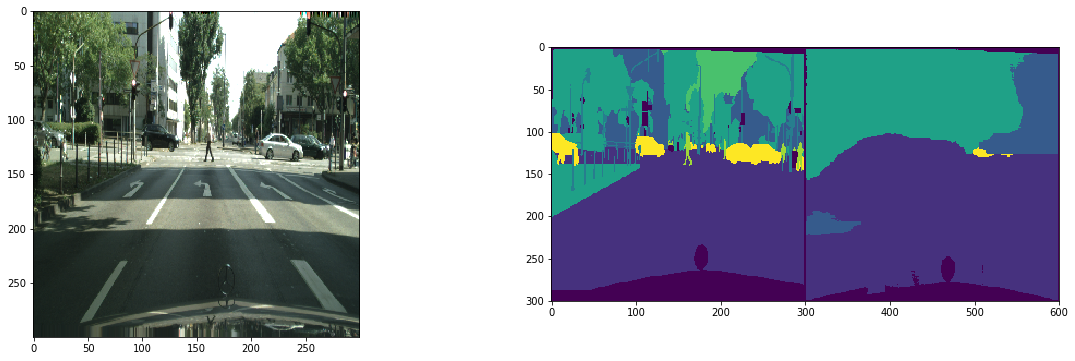

Test loss: 0.0955


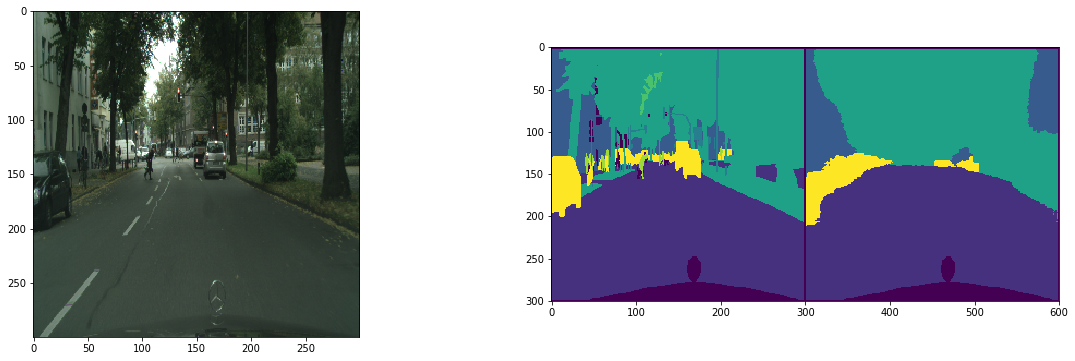

Test loss: 0.1431


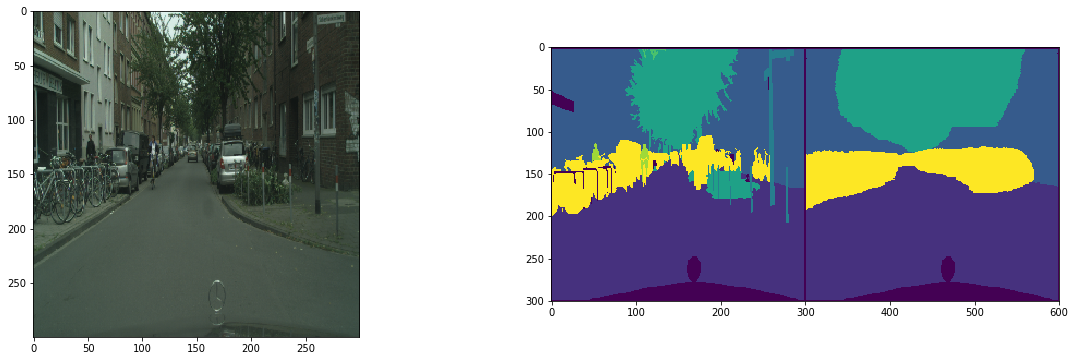

Test loss: 0.1902


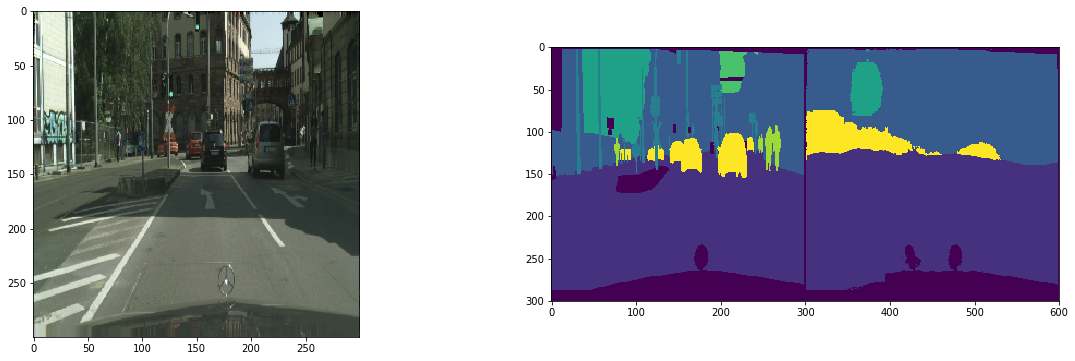

Test loss: 0.2387


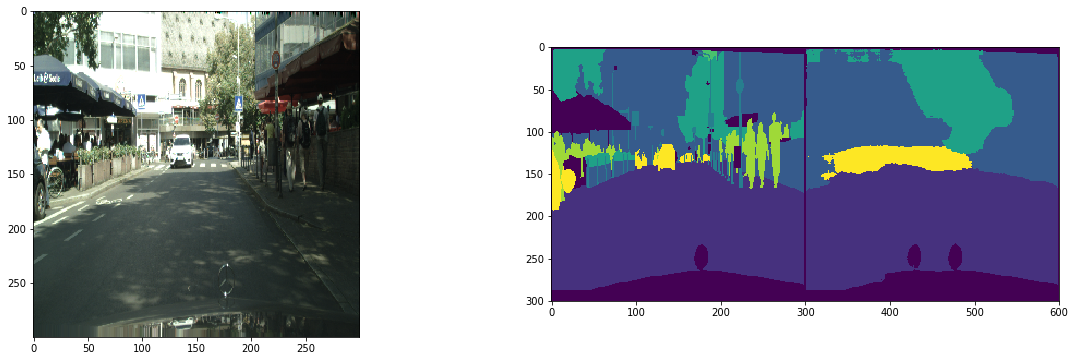

Test loss: 0.2863


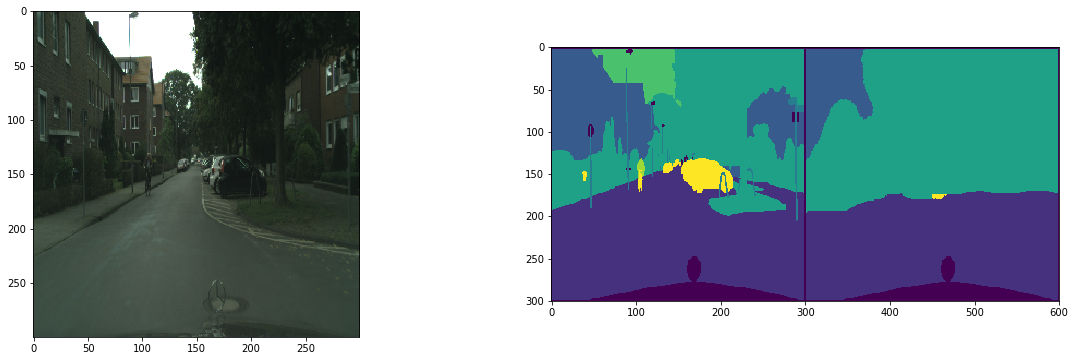

Test loss: 0.3342


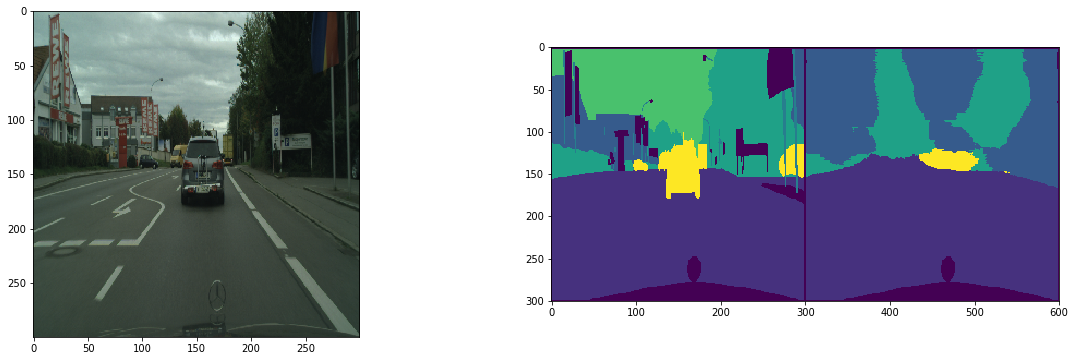

Test loss: 0.3818


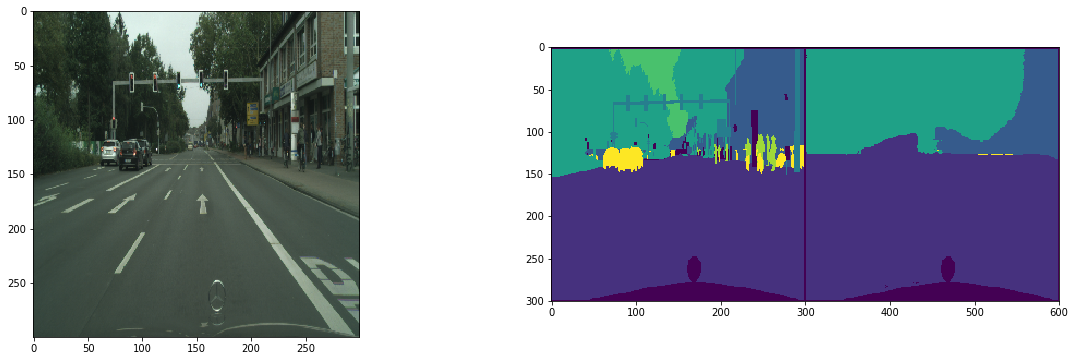

Test loss: 0.4293


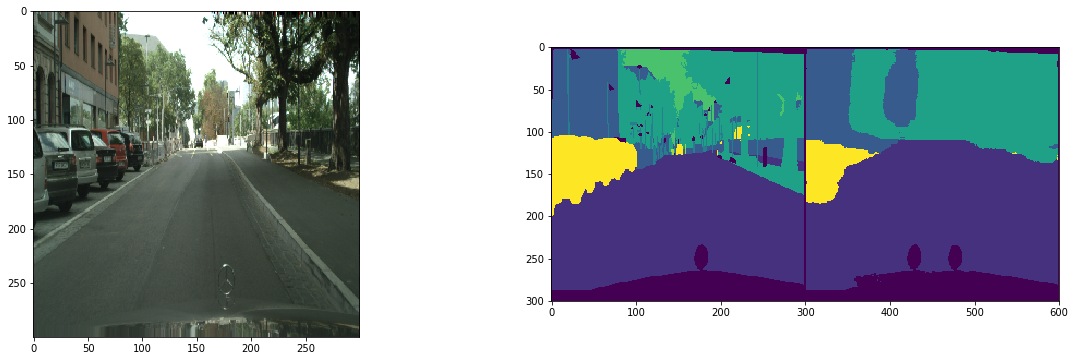

Test loss: 0.4771


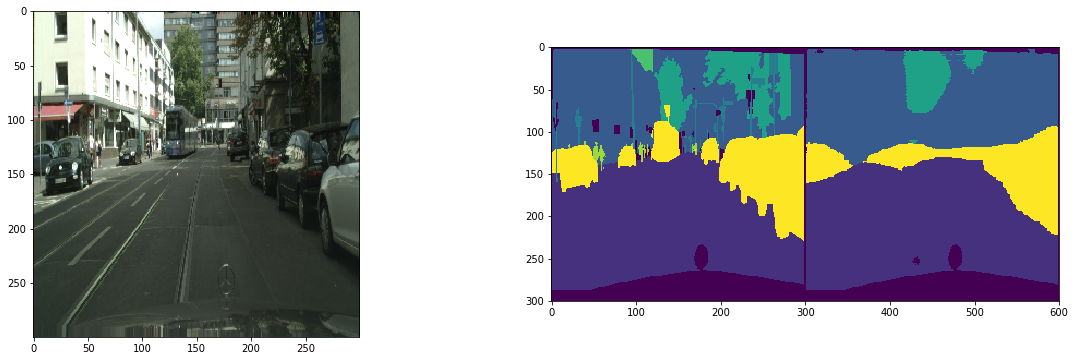

Test loss: 0.5265


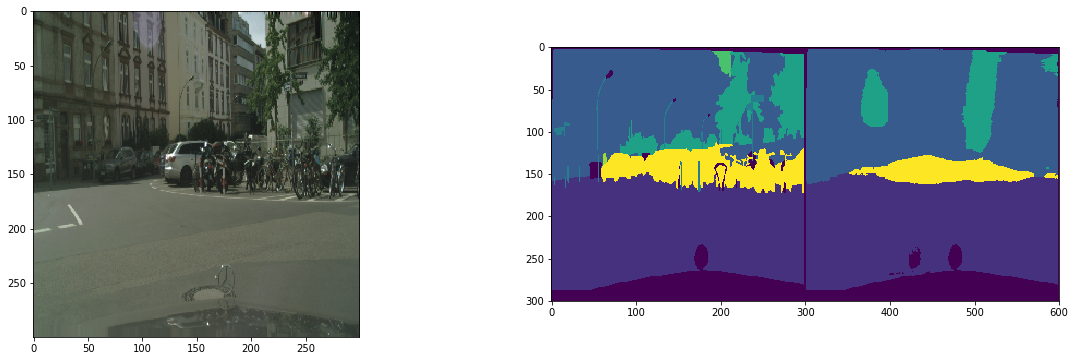

Test loss: 0.5737


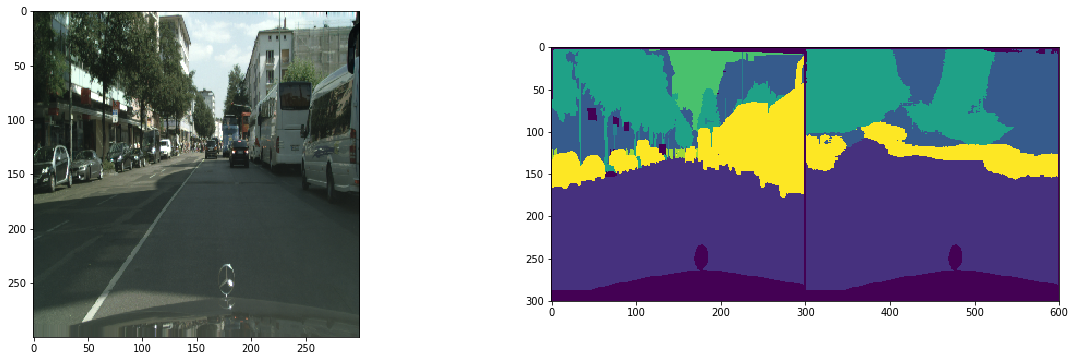

Test loss: 0.6220


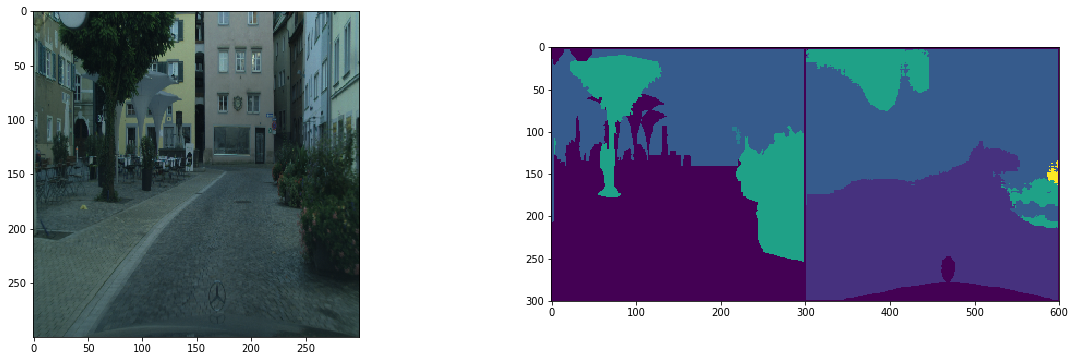

Test loss: 0.6697


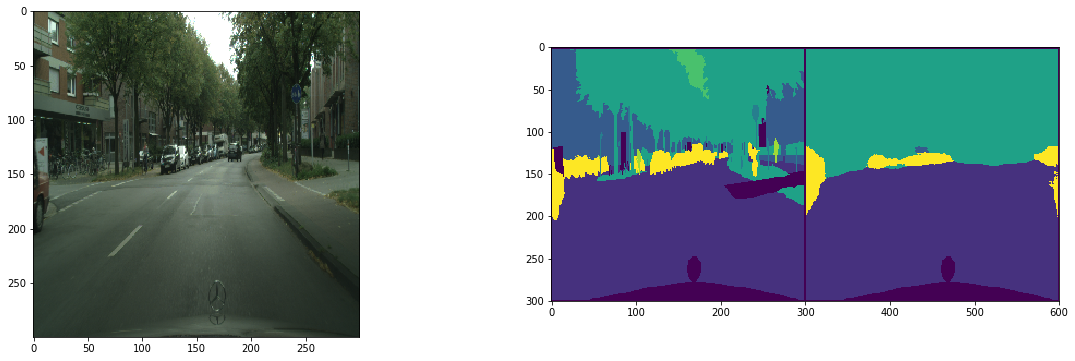

Test loss: 0.7193


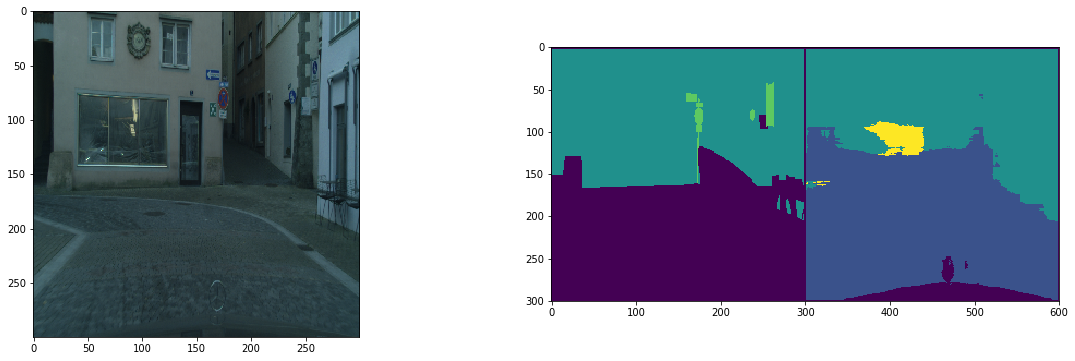

Test loss: 0.7686


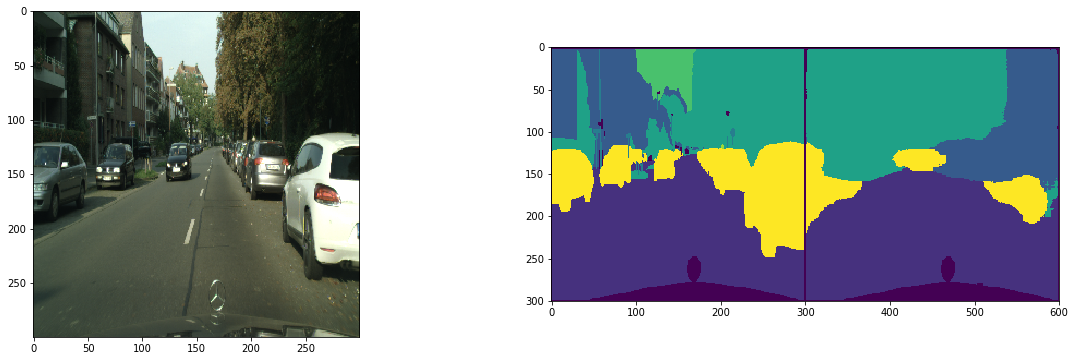

Test loss: 0.8160


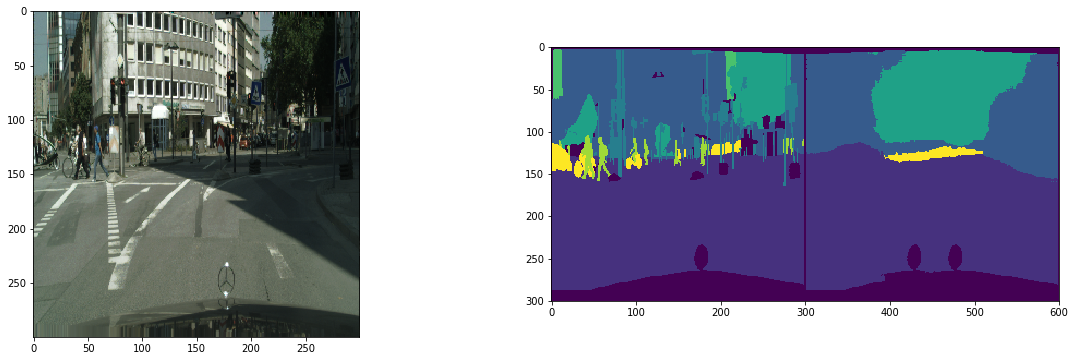

Test loss: 0.8650


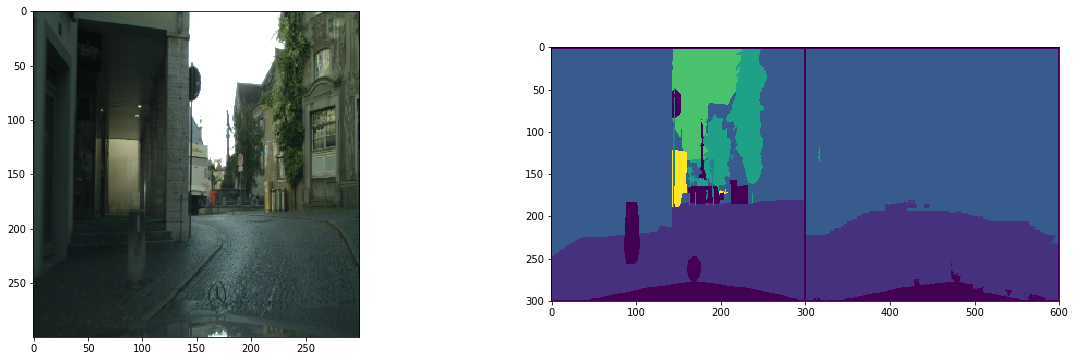

Test loss: 0.9129


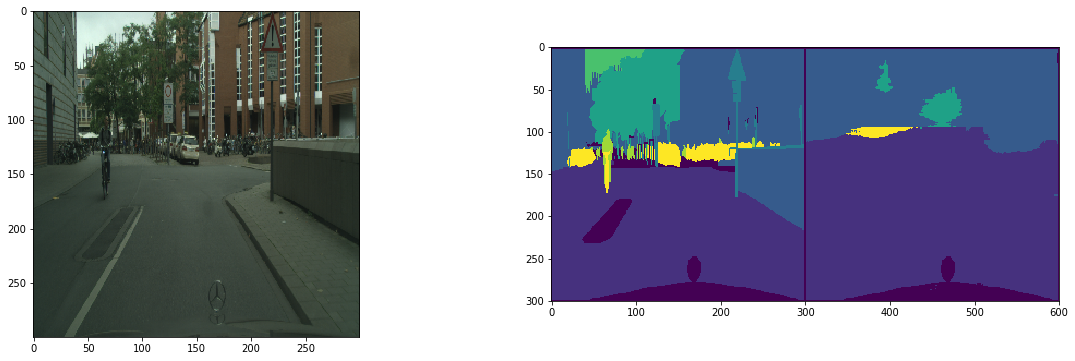

Test loss: 0.9613


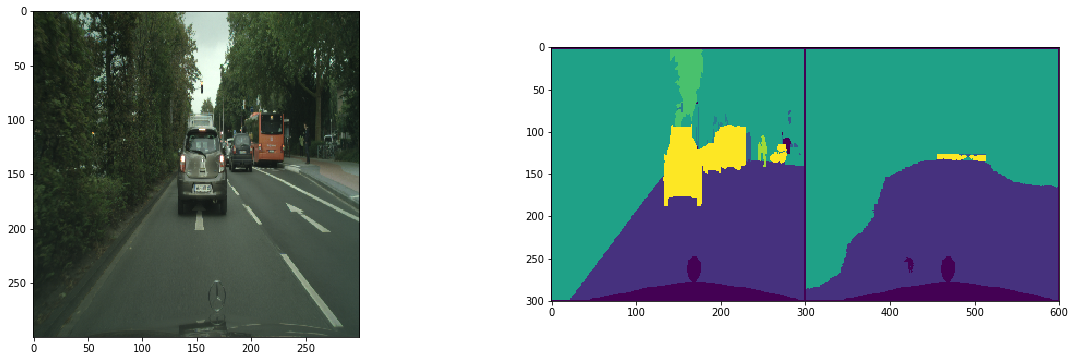

Test loss: 1.0096


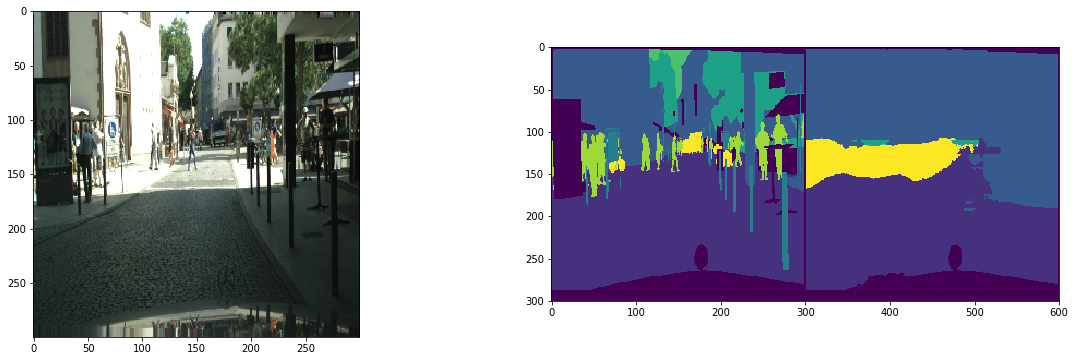

Test loss: 1.0590


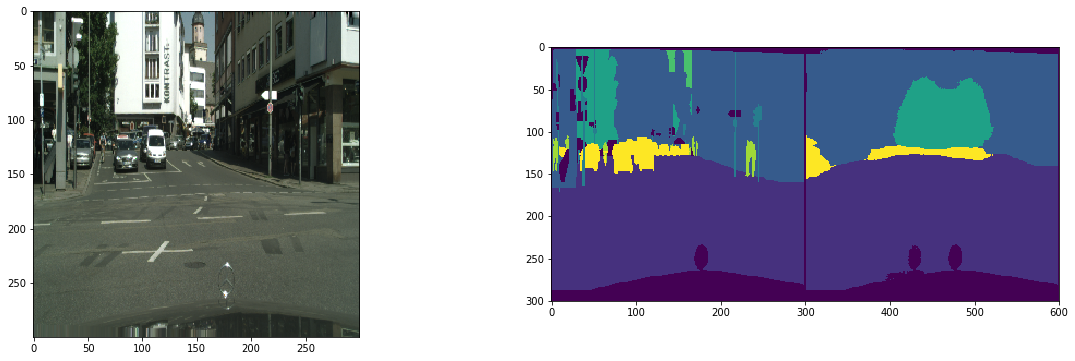

Test loss: 1.1091


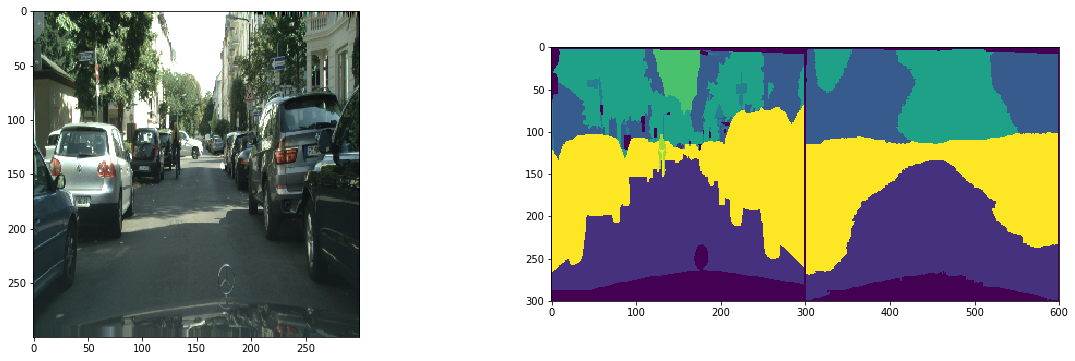

Test loss: 1.1582


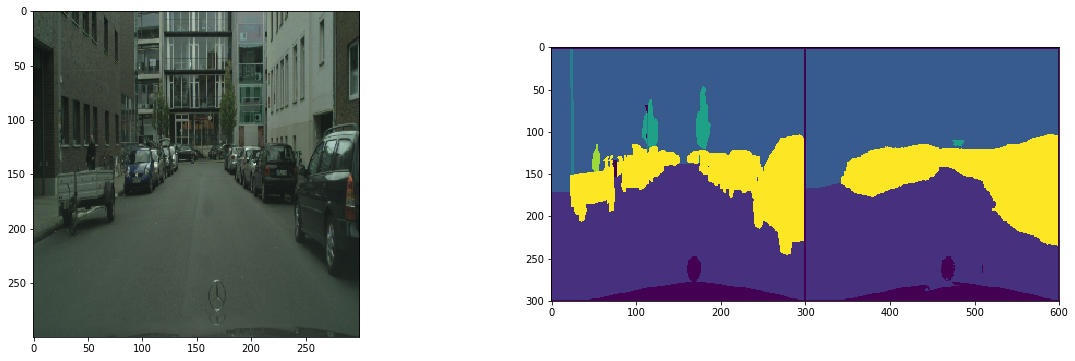

Test loss: 1.2064


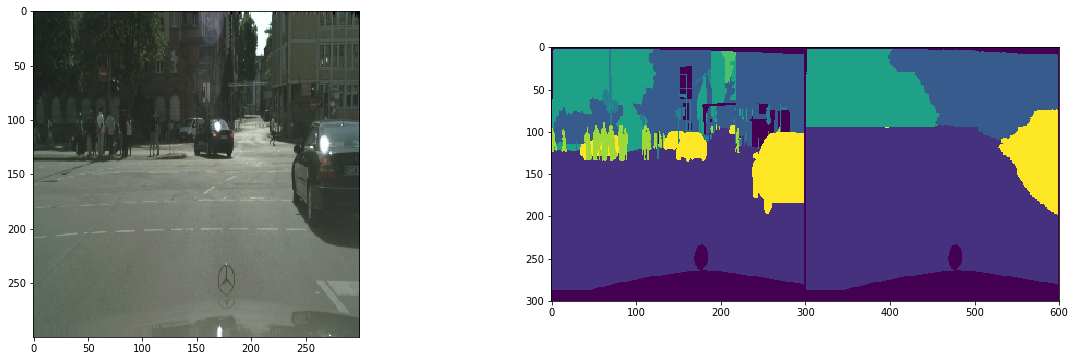

Test loss: 1.2535


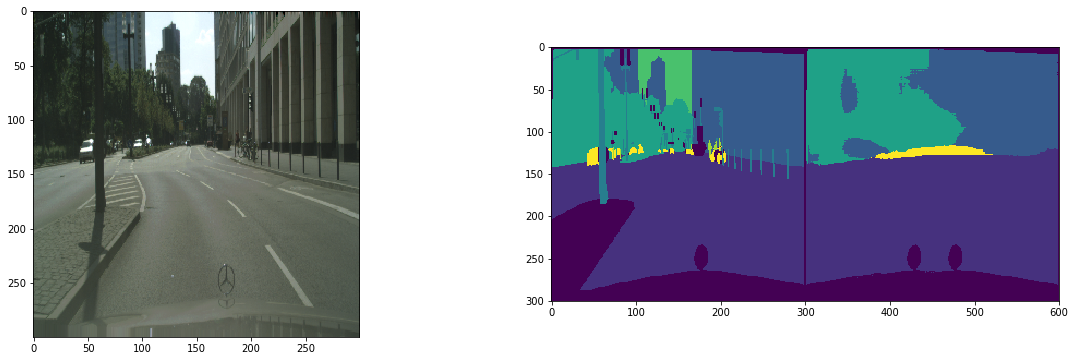

Test loss: 1.3017


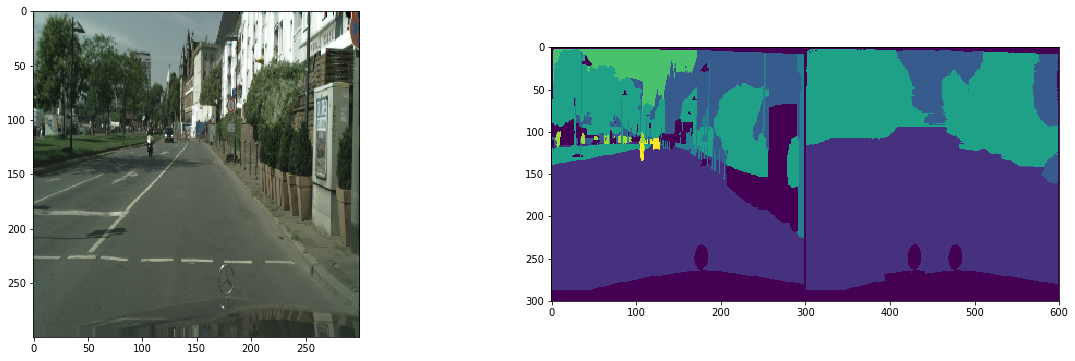

Test loss: 1.3494


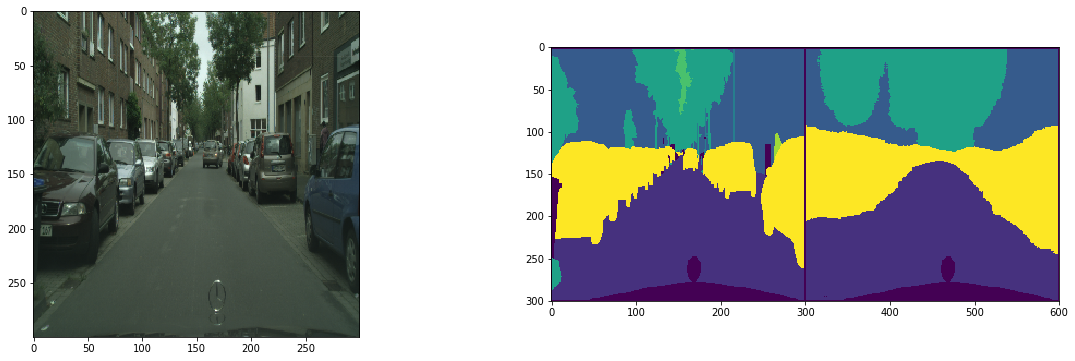

Test loss: 1.3981


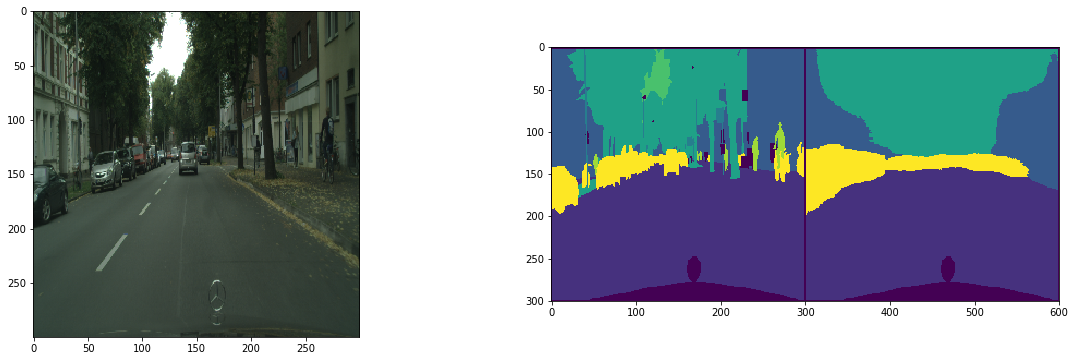

Test loss: 1.4475


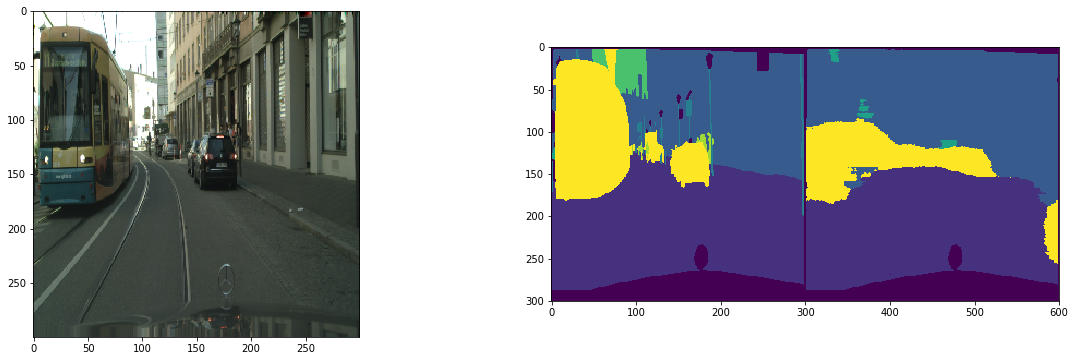

Test loss: 1.4956


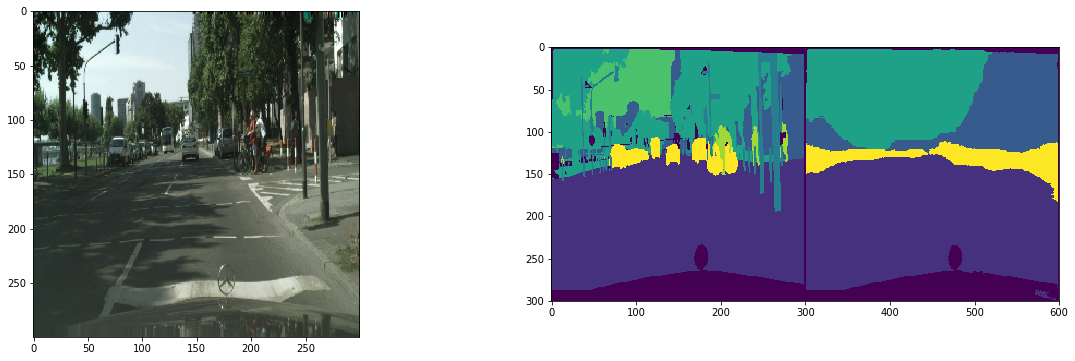

Test loss: 1.5430


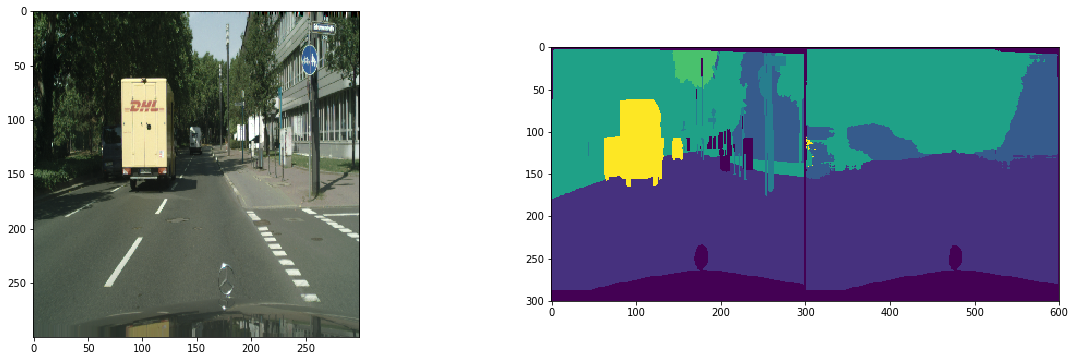

1.543045349419117

In [13]:
# see the test data
evaluate_model(Unet_model, testloader, loss_fn)